In [1]:
%load_ext autoreload

%autoreload 2
import pickle
import sys
import emcee
from astropy.table import Table, join
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules/')
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_fit_cluster_mass as fit
import mcmc
import CL_Likelihood_for_Mass_richness_relation as mr
import analysis_Mass_Richness_relation as analysis
import CL_fiducial_mass_richness_relation as cl
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

In [16]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin

In [17]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

dat_RM = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl')
dat_cosmodc2 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Galaxy_Cluster_Catalogs_details/cosmoDC2/SkySim5000_DM_halos.pkl')
dat_cosmodc2['M200c'] = dat_cosmodc2['baseDC2/sod_halo_mass']/0.71
dat_cosmodc2 = dat_cosmodc2

In [43]:
richness_catalog = Table({'obs':dat_RM['richness'], 'ra':dat_RM['ra'], 'dec':dat_RM['dec'],'redshift':dat_RM['redshift'], 'id':np.arange(len(dat_RM['redshift']))})
richness_catalog = richness_catalog[richness_catalog['obs'] > 20]

In [44]:
mass_catalog = Table({'obs':dat_cosmodc2['M200c'], 'ra':dat_cosmodc2['ra'], 'dec':dat_cosmodc2['dec'],'redshift':dat_cosmodc2['redshift'],'id':np.arange(len(dat_cosmodc2['redshift']))})
mass_catalog = mass_catalog[mass_catalog['redshift']<1.2]
mass_catalog = mass_catalog[mass_catalog['redshift']>.2]
mass_catalog = mass_catalog[mass_catalog['obs']>3e13]

In [45]:
match_table_my=cl.match_catalog(mass_catalog, richness_catalog, clevar=False)

In [46]:
match_table_clevar=cl.match_catalog(mass_catalog, richness_catalog, clevar=True)


## ClCatalog 1
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
* zmin|zmax from config value
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Cat1)
* 5,525/48,762 objects matched.

## Multiple match (catalog 2)
Finding candidates (Cat2)
* 4,219/4,313 objects matched.

## Finding unique matches of catalog 1
Unique Matches (Cat1)
* 4,824/48,762 objects matched.

## Finding unique matches of catalog 2
Unique Matches (Cat2)
* 4,219/4,313 objects matched.
Cross Matches (Cat1)
* 4,217/48,762 objects matched.
Cross Matches (Cat2)
* 4,217/4,313 objects matched.


In [49]:
match_table_clevar

id_1,ra_1,dec_1,z_1,mass_1,SkyCoord_1,mt_self_1,mt_other_1,mt_multi_self_1,mt_multi_other_1,mt_cross_1,halo_id,id_2,ra_2,dec_2,z_2,mass_2,SkyCoord_2,mt_self_2,mt_other_2,mt_multi_self_2,mt_multi_other_2,zmin,zmax,mt_cross_2
,,,,,"deg,deg",,,,,,,,,,,,"deg,deg",,,,,,,
str7,float64,float64,float64,float64,object,object,object,object,object,object,str7,str6,float64,float64,float32,float32,object,object,object,object,object,float32,float32,object
CL0,50.170715214292095,-39.51426485329993,0.20922179940446406,222022091351977.47,"50.170715214292095,-39.51426485329993",CL3011,CL3011,['CL3011'],['CL3011'],CL3011,CL0,CL3011,50.171684683898185,-39.514907321219695,0.20889707,34.129593,"50.171684683898185,-39.514907321219695",CL0,CL0,['CL0'],['CL0'],0.1484522,0.26934192,CL0
CL10000,71.29005267718743,-44.7344943960116,0.30136310413339307,196741615166016.9,"71.29005267718743,-44.7344943960116",CL4250,CL4250,['CL4250'],['CL4250'],CL4250,CL10000,CL4250,71.29096536791482,-44.73367969542807,0.3047634,34.877083,"71.29096536791482,-44.73367969542807",CL10000,CL10000,['CL10000'],['CL10000'],0.23952523,0.37000158,CL10000
CL1001,59.64425373506909,-40.671884355433846,0.6191493897344609,93256409157228.17,"59.64425373506909,-40.671884355433846",CL3721,CL3721,['CL3721'],['CL3721'],CL3721,CL1001,CL3721,59.64425048794608,-40.67195513566912,0.62082034,24.610487,"59.64425048794608,-40.67195513566912",CL1001,CL1001,['CL1001'],['CL1001'],0.5397793,0.7018614,CL1001
CL10015,71.10342942370357,-44.62046986933901,0.3065484909974734,131956643695774.66,"71.10342942370357,-44.62046986933901",CL4246,CL4246,['CL4246'],['CL4246'],CL4246,CL10015,CL4246,71.10355193366124,-44.620622906055914,0.29600188,52.481323,"71.10355193366124,-44.620622906055914",CL10015,CL10015,"['CL10007', 'CL10015', 'CL10008', 'CL10039']","['CL10007', 'CL10015', 'CL10008', 'CL10039']",0.23120178,0.360802,CL10015
CL10033,70.43764310716931,-45.455582753457314,0.36984896816355595,98334370305442.27,"70.43764310716931,-45.455582753457314",CL4293,CL4293,['CL4293'],['CL4293'],CL4293,CL10033,CL4293,70.43777085523578,-45.4557448856578,0.37054276,28.3327,"70.43777085523578,-45.4557448856578",CL10033,CL10033,['CL10033'],['CL10033'],0.30201563,0.4390699,CL10033
CL10057,71.7798799415802,-44.86987371533338,0.4464505144860875,60373308003515.49,"71.7798799415802,-44.86987371533338",CL4255,CL4255,['CL4255'],['CL4255'],CL4255,CL10057,CL4255,71.77749744099319,-44.86932602581692,0.4485337,28.714075,"71.77749744099319,-44.86932602581692",CL10057,CL10057,['CL10057'],['CL10057'],0.37610704,0.5209604,CL10057
CL10063,71.23244452631572,-45.45430469191074,0.44523913469188425,1123629135704698.6,"71.23244452631572,-45.45430469191074",CL4221,CL4221,['CL4221'],['CL4221'],CL4221,CL10063,CL4221,71.22656019720333,-45.45427008968985,0.4459376,164.87997,"71.22656019720333,-45.45427008968985",CL10063,CL10063,['CL10063'],['CL10063'],0.37364072,0.5182345,CL10063
CL10085,70.81482069373644,-44.95666622958903,0.509536399620192,112337142821498.6,"70.81482069373644,-44.95666622958903",CL4253,CL4253,['CL4253'],['CL4253'],CL4253,CL10085,CL4253,70.8147072579209,-44.95680415367155,0.506278,29.400549,"70.8147072579209,-44.95680415367155",CL10085,CL10085,['CL10085'],['CL10085'],0.43096408,0.5815919,CL10085


In [50]:
#match_table_clevar
match_table_clevar['M200c'] = match_table_clevar['mass_1']
match_table_clevar['richness'] = match_table_clevar['mass_2']

In [59]:
match_table_clevar.colnames

['id_1',
 'ra_1',
 'dec_1',
 'z_1',
 'mass_1',
 'SkyCoord_1',
 'mt_self_1',
 'mt_other_1',
 'mt_multi_self_1',
 'mt_multi_other_1',
 'mt_cross_1',
 'halo_id',
 'id_2',
 'ra_2',
 'dec_2',
 'z_2',
 'mass_2',
 'SkyCoord_2',
 'mt_self_2',
 'mt_other_2',
 'mt_multi_self_2',
 'mt_multi_other_2',
 'zmin',
 'zmax',
 'mt_cross_2',
 'M200c',
 'richness']

In [56]:
save_pickle(Table(match_table_clevar), '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/clevar_proximity_matching_dm_halos_redmapper_clusters.pkl')

[]

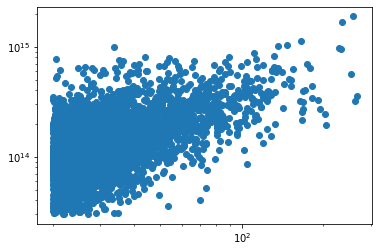

In [58]:
plt.scatter(match_table_clevar['richness'], match_table_clevar['M200c'])
plt.loglog()

In [34]:
#binned_clevar=cl.make_binned(match_table_clevar['mass_1'], match_table_clevar['mass_2'], match_table_clevar['z_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

In [35]:
binned_my=cl.make_binned(match_table_my['obs_1'], match_table_my['obs_2'], match_table_my['redshift_1'], Z_bin = Z_bin, Richness_bin = Obs_bin)

In [36]:
n_per_bin=np.array([len(z) for z in binned_my['redshift_in_bin']])

[]

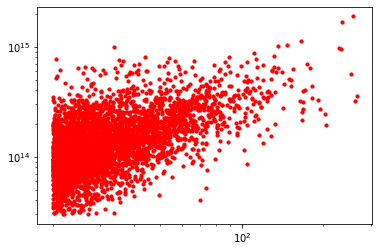

In [37]:
#plt.scatter(match_table_clevar['mass_2'],match_table_clevar['mass_1'],c='g')
plt.scatter(match_table_my['obs_2'],match_table_my['obs_1'],c='r', s=10)
plt.loglog()

In [38]:
binned_my.keys()

dict_keys(['Z_bin', 'Obs_bin', 'z_mean', 'logrichness', 'richness_err', 'm200', 'm200_err', 'n_stack', 'logrichness_in_bin', 'redshift_in_bin', 'M200c_in_bin', 'logrichness_err_in_bin', 'redshift_err_in_bin'])

In [39]:
logm=np.log10(np.array(binned_my['m200']))
logm_err=np.array(binned_my['m200_err'])/(np.log(10)*np.array(binned_my['m200']))
richness_individual = 10**np.array(binned_my['logrichness_in_bin'])
richness = np.array([np.mean(richness_individual[i]) for i in range(len(richness_individual))])
richness_err = np.array([np.std(richness_individual[i]) for i in range(len(richness_individual))])
z_individual = binned_my['redshift_in_bin']
z = np.array([np.mean(z_individual[i]) for i in range(len(z_individual))])
z_err = 0
weight_individual = None
Gamma=.7

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
WL_Mlambda = mr.WL_Mass_Richness(logm=logm, logm_err=logm_err, 
                                richness=richness, richness_err=richness_err, 
                                z=z, z_err=z_err,
                                richness_individual=np.array(richness_individual), z_individual=np.array(z_individual),
                                n_cluster_per_bin=None,
                                weights_individual=z_individual)
WL_Mlambda.set_pivot_values(analysis.z0, analysis.richness0)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [41]:
def lnL_WL(theta, likelihood, Gamma):
    if likelihood=='classic': return WL_Mlambda.lnLikelihood_binned_classic(theta)
    if likelihood=='individual_zrichness': return WL_Mlambda.lnLikelihood_individual_zrichness(theta, Gamma)
    if likelihood=='intrinsic_scatter': return WL_Mlambda.lnLikelihood_binned_intrinsic_scatter(theta)

In [42]:
sampler = mcmc.constraint_mcmc(lnL_WL, ('classic', .7), theta0=[14,0,1,], npath=300, nwalkers=200)

100%|██████████| 300/300 [00:03<00:00, 93.32it/s]


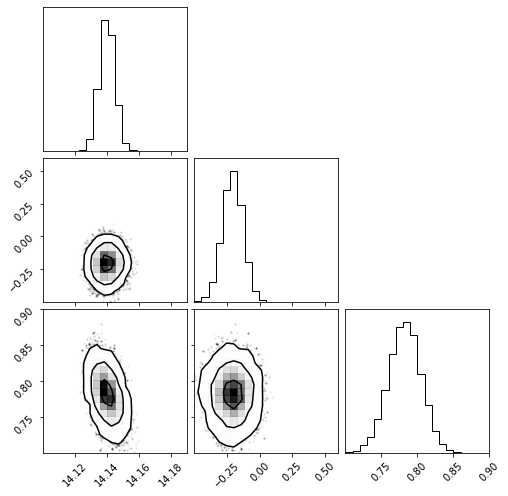

In [1081]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)

sample_cut = sampler[15000:]
fig = corner.corner(
sample_cut[sample_cut[:,0]>0],
bins=20, levels=(sigma1, sigma2,sigma3),color='k',range=[(14.1,14.19), (-0.5, 0.6), (0.7, 0.9),])#(0,.4)])

In [1061]:
np.mean(sample_cut[sample_cut[:,3]>0],axis=0)

IndexError: index 3 is out of bounds for axis 1 with size 3

# purity and completness

In [809]:
logm = np.linspace(np.log10(3e13), 15, 10)
richness=np.linspace(20, 100, 10)
z=np.linspace(.2, 1., 10)

In [810]:
binned_true_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(mass_catalog['obs']), mass_catalog['redshift'], bins=[logm, z])

In [811]:
binned_matched_mass_cat, axis1_mass, axis2_z =np.histogram2d(np.log10(match_table_my['obs_1']), match_table_my['redshift_1'], bins=[logm, z])

In [812]:
binned_true_richness_cat, axis1_richness, axis2_z =np.histogram2d(richness_catalog['obs'], richness_catalog['redshift'], bins=[richness, z])

In [813]:
binned_matched_richness_cat, axis1_richness, axis2_z =np.histogram2d(match_table_my['obs_2'], match_table_my['redshift_2'], bins=[richness, z])

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


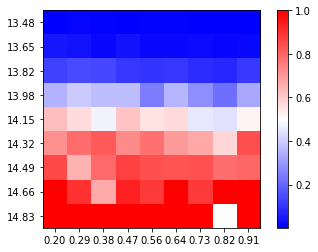

In [814]:
completness = binned_matched_mass_cat/binned_true_mass_cat
plt.imshow(completness, cmap='bwr')
plt.yticks(ticks=np.arange(len(axis1_mass)-1), labels=[f'{s:.2f}' for s in axis1_mass]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.colorbar()

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


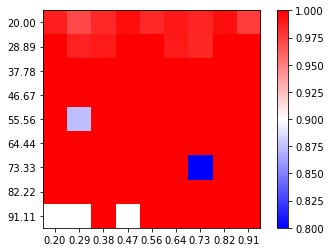

In [815]:
purity = binned_matched_richness_cat/binned_true_richness_cat
plt.yticks(ticks=np.arange(len(axis1_richness)-1), labels=[f'{s:.2f}' for s in axis1_richness]) 
plt.xticks(ticks=np.arange(len(axis2_z)-1), labels=[f'{s:.2f}' for s in axis2_z]) 
plt.imshow(purity, cmap='bwr')
plt.colorbar()

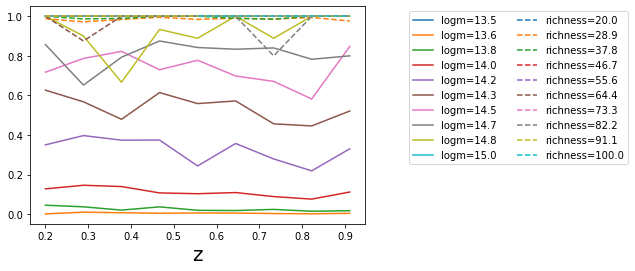

In [803]:
for i, m in enumerate(logm):
    plt.plot(axis2_z[:-1], completness[i-1,:], label=f'logm={m:.1f}')
for i, rich in enumerate(richness):
    plt.plot(axis2_z[:-1], purity[i-1,:], '--', label=f'richness={rich:.1f}')
plt.xlabel('z', fontsize=20)
plt.legend(ncol=2,bbox_to_anchor=(0,0,1.8,1), )